# Notebook to demonstrate Zero shot and Few shot Learning

In [ ]:
import pandas as pd 
import numpy as np
from langchain_groq.chat_models import ChatGroq


# Create list for easy access of activities
ACTIVITIES = {1: 'WALKING',2: 'WALKING_UPSTAIRS',3: 'WALKING_DOWNSTAIRS',4: 'SITTING',5: 'STANDING',6: 'LAYING',}

In [ ]:
# Groq API and Models 
Groq_Token = "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"  # Do not share this key with anyone

groq_models = {"llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

**NOTE : DO NOT SHARE THE API KEY WITH ANYONE. DO NOT COMMIT THE API KEY TO GITHUB.**

Always do a sanity check before committing the code to github. If the key is found in the code, you will be penalized with a 0.5 marks deduction.

#DATA EXTRACTION

Shape of X_train_acc: (7352, 384)
Shape of X_test_acc: (2947, 384)
Shape of y_train_acc: (7352, 1)
Shape of y_test_acc: (2947, 1)
Shape of X_train_tsfel: (7352, 40)
Shape of X_test_tsfel: (2947, 40)
Accuracy: 0.6824
Precision: 0.6861
Recall: 0.6824


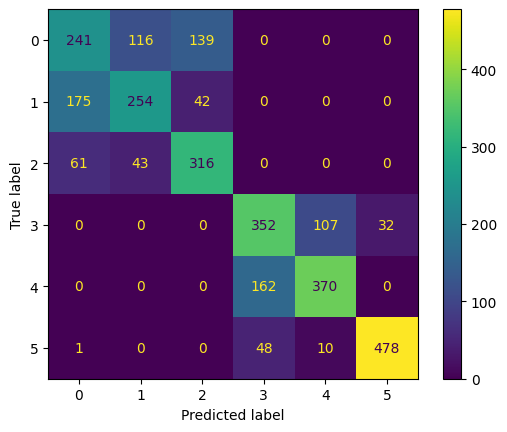

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsfel
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import warnings

# Suppressing FutureWarnings and UserWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load dataset paths
train_data_path = "UCI HAR Dataset/train/Inertial Signals/"
test_data_path = "UCI HAR Dataset/test/Inertial Signals/"

# Load train and test accelerometer data
train_acc_x = pd.read_csv(f"{train_data_path}total_acc_x_train.txt", delim_whitespace=True, header=None)
train_acc_y = pd.read_csv(f"{train_data_path}total_acc_y_train.txt", delim_whitespace=True, header=None)
train_acc_z = pd.read_csv(f"{train_data_path}total_acc_z_train.txt", delim_whitespace=True, header=None)

test_acc_x = pd.read_csv(f"{test_data_path}total_acc_x_test.txt", delim_whitespace=True, header=None)
test_acc_y = pd.read_csv(f"{test_data_path}total_acc_y_test.txt", delim_whitespace=True, header=None)
test_acc_z = pd.read_csv(f"{test_data_path}total_acc_z_test.txt", delim_whitespace=True, header=None)

# Concatenate accelerometer data
X_train_acc = np.concatenate((train_acc_x, train_acc_y, train_acc_z), axis=1)
X_test_acc = np.concatenate((test_acc_x, test_acc_y, test_acc_z), axis=1)

print(f"Shape of X_train_acc: {X_train_acc.shape}")
print(f"Shape of X_test_acc: {X_test_acc.shape}")

# Load train and test labels
y_train_acc = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['Activity'])
y_test_acc = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['Activity'])

print(f"Shape of y_train_acc: {y_train_acc.shape}")
print(f"Shape of y_test_acc: {y_test_acc.shape}")

# Featurize the data using TSFEL
def obtain_features(X, max_readings=500):
    """Extract features from time series data using TSFEL."""
    cfg = tsfel.get_features_by_domain("statistical")  # Specify the domains you need
    tsfel_features = []

    for sample in X:
        # Optionally slice the data to the first `max_readings`
        sample = sample[:max_readings]
        
        # Extract features for each sample with the progress bar disabled
        sample_features = tsfel.time_series_features_extractor(cfg, sample, verbose=0)
        tsfel_features.append(sample_features.values.flatten())

    return pd.DataFrame(np.array(tsfel_features))

# Extract features from training and testing data
X_train_tsfel = obtain_features(X_train_acc)
X_test_tsfel = obtain_features(X_test_acc)

print(f"Shape of X_train_tsfel: {X_train_tsfel.shape}")
print(f"Shape of X_test_tsfel: {X_test_tsfel.shape}")

# Train a Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train_tsfel, y_train_acc)

# Predict and evaluate
y_pred = clf.predict(X_test_tsfel)

# Evaluate the classifier
accuracy = accuracy_score(y_test_acc, y_pred)
precision = precision_score(y_test_acc, y_pred, average='weighted')
recall = recall_score(y_test_acc, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_acc, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.show()


# Zero Shot 

In [ ]:
# Statement 
sentence = "The product quality is amazing but the delivery was delayed. However I am happy with the customer service."

# System Prompts 
query = f"""
* You are a sentiment analysis model. 
* Your task is to analyze the sentiment expressed in the given text and classify it as 'positive', 'negative', or 'neutral'. 
* Provide the sentiment label and, if necessary, a brief explanation of your reasoning.

Sentence: {sentence}
""" 

# To use Groq LLMs 
model_name = "llama3-8b" # We can choose any model from the groq_models dictionary
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

print(answer.content)

Sentiment: Mixed (Neutral with a slight positive bias)

Reasoning: The sentence expresses a mixed sentiment, with both positive and negative comments. The phrase "The product quality is amazing" is clearly positive, indicating a high level of satisfaction with the product. However, the phrase "the delivery was delayed" is negative, indicating a problem with the delivery process. The sentence also mentions "I am happy with the customer service", which is another positive comment. Overall, the positive comments outweigh the negative one, but the mixed sentiment prevents me from classifying it as purely positive or negative.


In [ ]:
from transformers import pipeline

# Initialize a pipeline for zero-shot classification
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define possible activities
candidate_labels = list(set(train_labels))

# Function to predict using Zero-Shot Learning
def zero_shot_predict(data, candidate_labels):
    predictions = []
    for sample in data:
        # Featurize sample data (this step will depend on how your data is structured)
        sample_text = " ".join(map(str, sample.flatten()))
        result = zero_shot_classifier(sample_text, candidate_labels)
        predictions.append(result['labels'][0])
    return predictions

# Predict on test data
zero_shot_predictions = zero_shot_predict(test_data, candidate_labels)


# Few Shot

In [ ]:
# Statement 
sentence = "The product quality is amazing but the delivery was delayed. However I am happy with the customer service."

# System Prompts 
query = f"""
* You are a sentiment analysis model. 
* Your task is to analyze the sentiment expressed in the given text and classify it as 'positive', 'negative', or 'neutral'. 
* Provide the sentiment label and, if necessary, a brief explanation of your reasoning.

Here are few examples:
1. Sentence: 'The customer service was excellent, and I received my order quickly.'
Sentiment: Positive

2. Sentence: 'The food was bland and the service was slow.'
Sentiment: Negative

3. Sentence: 'The product is okay, but it's not worth the price.'
Sentiment: Neutral

Sentence: {sentence}
""" 

# To use Groq LLMs 
model_name = "llama3-8b" # We can choose any model from the groq_models dictionary
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

print(answer.content)

Based on the given sentence, I would classify the sentiment as:

Sentiment: Positive

Reasoning: Although the sentence mentions a delay in delivery, which could be considered a negative aspect, the overall tone is positive due to the use of the word "amazing" to describe the product quality and the fact that the customer is "happy" with the customer service. The negative aspect is not strong enough to outweigh the positive comments, leading me to classify the sentiment as positive.
